## Different implementation of a cuSignal kernel.


In [1]:
import matplotlib.pyplot as plt

import numpy as np

import cupy as cp
import cusignal
from numba import cuda, float64

from bootstrap import default


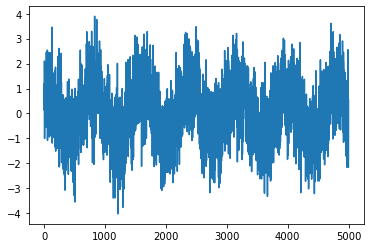

In [8]:
signal, references, window = default(f0=[2.5])

plt.plot(signal[0,:])

In [9]:
import numpy as np
import cupy as cp
import cusignal

import concurrent.futures

def init_gpu(references, window):
    """ Initialize GPU memory 
    Store the reference and window data in the gpu memory and return the handles. 
    
    Arguments:
    - reference: A (M, k) numpy array (np.float64) containing the reference(s) for convolution. Each column in reference will generate a seperate demodulation result per column in signal. 
	- windows: A (q) numpy array (np.float64) containing the window data. 
    Returns:
    - gpuR, gpuW: references to the memory on the GPU
    """
    gpuR = cp.asarray(references)
    gpuW = cp.asarray(window)
    return gpuR, gpuW

def cusignal_go(signal, gpuR, gpuW):
    """ Run demodulation on the GPU
    First store the reference and window data on the GPU using the init_gpu() function. The object returned are 
    required for this function.

    Returns:
    - A (M, N) numpy array (np.float64) buffer for the average of the convolution result along the second dimension of the signal data. This can be considered as the demodulation result for each demodulation channel.  """
    N, k = signal.shape
    M = gpuR.shape[0]

    gpuS = cp.asarray(signal)
    gpuW = cp.tile(gpuW, (N,1))

    results = np.zeros((M, N))
    for i in range(M):
        buffer = cp.multiply(gpuS, gpuR[i,:])
        buffer = cusignal.fftconvolve(buffer, gpuW, mode='same', axes=1)
        buffer = cp.mean(buffer, axis=1)
        results[i,:] = cp.asnumpy(buffer)

    return results

cuSignal (+CuPy):
49.7 ms ± 331 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


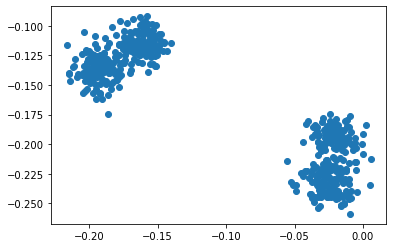

In [10]:
# Run demodulation using a cusignal implementation
gpuR, gpuW = init_gpu(references, window)

averages = cusignal_go(signal, gpuR, gpuW)
plt.plot(*averages, 'o')

print("cuSignal (+CuPy):")
%timeit cusignal_go(signal, gpuR, gpuW)